In [2]:
# --- Ячейка 1: Импорт и настройка ---

# Импортируем все необходимые библиотеки
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import timm
import matplotlib.pyplot as plt
import numpy as np
import os
import random

# Функция для фиксации случайных чисел.
# Это нужно для того, чтобы при каждом запуске код давал одинаковый результат.
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Устанавливаем наш "счастливый" номер для воспроизводимости
SEED = 42
set_seed(SEED)

# Задаем основные параметры, которые будем использовать в проекте
DATA_PATH = '../data/raw' # Путь к папке с картинками. '../' значит "подняться на одну папку вверх"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Проверяем, есть ли у нас GPU
BATCH_SIZE = 16 # Сколько картинок модель будет обрабатывать за один раз
IMG_SIZE = 224 # К какому размеру приводить все картинки

# Выводим информацию, чтобы убедиться, что все правильно
print(f"Проект будет выполняться на устройстве: {DEVICE}")
print(f"Путь к данным: {os.path.abspath(DATA_PATH)}")
if not os.path.exists(DATA_PATH):
    print("!!! ОШИБКА: Папка с данными не найдена. Проверь путь в DATA_PATH. !!!")
else:
    print("Папка с данными успешно найдена.")

Проект будет выполняться на устройстве: cpu
Путь к данным: d:\Unic\7 семестр\машинки\1lb\data\raw
Папка с данными успешно найдена.


In [3]:
# --- Ячейка 2: Загрузка, трансформация и разделение данных ---

# 1. Определяем "рецепты" обработки изображений (трансформации)

# Рецепт для ОБУЧАЮЩИХ данных (с аугментацией)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Рецепт для ПРОВЕРОЧНЫХ данных (без аугментации)
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Загружаем все изображения из папки
# ImageFolder сам найдет классы по названиям папок: 'cars', 'bicycles', 'motorcycles'
full_dataset = datasets.ImageFolder(DATA_PATH, transform=train_transforms)

# 3. Разделяем наш датасет на две части: 80% на обучение, 20% на валидацию
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Применяем к валидационной части трансформации БЕЗ аугментации
val_dataset.dataset.transform = val_transforms

# 4. Создаем DataLoaders - "податчики" данных для модели
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 5. Выводим итоговую информацию для проверки
class_names = full_dataset.classes
print(f"Найденные классы: {class_names}")
print(f"Всего изображений: {len(full_dataset)}")
print(f"Размер обучающей выборки: {len(train_dataset)}")
print(f"Размер валидационной выборки: {len(val_dataset)}")

Найденные классы: ['bicycles', 'cars', 'motorcycles']
Всего изображений: 1039
Размер обучающей выборки: 831
Размер валидационной выборки: 208


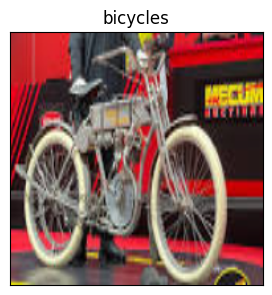

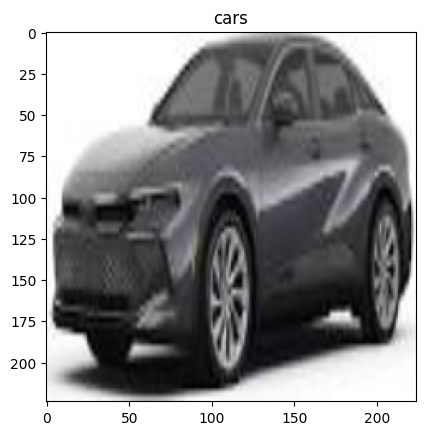

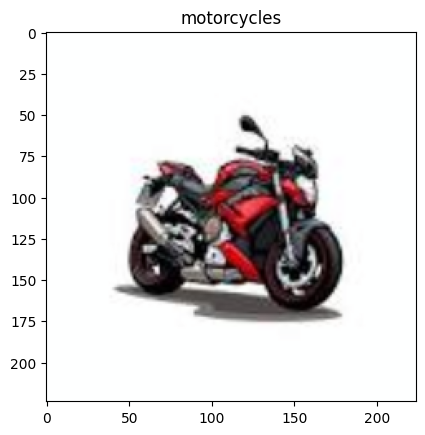

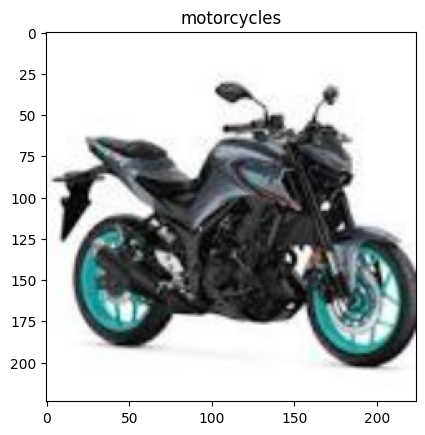

In [4]:
# --- Ячейка 3: Визуализация данных ---

# Создаем функцию для отображения изображений-тензоров
def imshow(inp, title=None):
    """Отображает тензор как изображение."""
    # PyTorch-тензоры имеют формат (Цвет, Высота, Ширина),
    # а для отображения нужен (Высота, Ширина, Цвет). Меняем их местами.
    inp = inp.numpy().transpose((1, 2, 0))
    
    # Мы нормализовали данные при загрузке, теперь нужно выполнить обратную операцию,
    # чтобы вернуть цвета в привычный диапазон [0, 1] для корректного отображения.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) # Убеждаемся, что значения находятся в диапазоне [0, 1]
    
    # Отображаем изображение
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Получаем один "пакет" (батч) данных из обучающего загрузчика
# iter(train_loader) создает объект для перебора, next() получает следующий элемент
inputs, classes = next(iter(train_loader))

# Создаем сетку для отображения нескольких картинок
# Мы покажем первые 4 картинки из этого батча
fig = plt.figure(figsize=(15, 10))
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    imshow(inputs[i], title=class_names[classes[i]])

In [5]:
# --- Ячейка 4: Подготовка моделей ---

# Функция для создания модели
def get_model(model_name, num_classes=3, pretrained=True):
    """
    Загружает предобученную модель из timm, "замораживает" ее веса
    и заменяет последний слой (классификатор).
    """
    # 1. Загружаем предобученную модель
    model = timm.create_model(model_name, pretrained=pretrained)

    # 2. "Замораживаем" все параметры модели.
    # Мы говорим PyTorch, что не нужно вычислять градиенты для этих слоев,
    # т.е. мы не будем их обучать.
    for param in model.parameters():
        param.requires_grad = False

    # 3. Находим имя и количество входных признаков у последнего слоя
    # У разных моделей этот слой называется по-разному (fc, classifier, head.fc)
    if 'resnet' in model_name:
        in_features = model.fc.in_features
        # Заменяем последний слой на новый, который подходит для нашей задачи
        model.fc = nn.Linear(in_features, num_classes)
    elif 'efficientnet' in model_name:
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
    # Добавь сюда другие семейства моделей, если захочешь
    
    print(f"Модель {model_name} подготовлена. Последний слой заменен.")
    return model

# --- Создаем наши две модели ---
NUM_CLASSES = len(class_names) # Получаем количество классов (у нас их 3)

# Модель 1: ResNet18
model_resnet = get_model('resnet18', num_classes=NUM_CLASSES)
# Перемещаем модель на наше устройство (CPU или GPU)
model_resnet.to(DEVICE)

print("\nСтруктура ResNet18 (конец):")
# Выведем только "голову" модели, чтобы убедиться, что out_features=3
print(model_resnet.fc)

print("-" * 30)

# Модель 2: EfficientNet B0
model_efficientnet = get_model('efficientnet_b0', num_classes=NUM_CLASSES)
model_efficientnet.to(DEVICE)

print("\nСтруктура EfficientNet_b0 (конец):")
print(model_efficientnet.classifier)

'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /timm/resnet18.a1_in1k/resolve/main/model.safetensors (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001DEB5ABE280>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: cf62090c-dc80-4941-875d-d95fbd44df3b)')' thrown while requesting HEAD https://huggingface.co/timm/resnet18.a1_in1k/resolve/main/model.safetensors
Retrying in 1s [Retry 1/5].
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

c:\Users\k9514\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\k9514\.cache\huggingface\hub\models--timm--resnet18.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Модель resnet18 подготовлена. Последний слой заменен.

Структура ResNet18 (конец):
Linear(in_features=512, out_features=3, bias=True)
------------------------------


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Модель efficientnet_b0 подготовлена. Последний слой заменен.

Структура EfficientNet_b0 (конец):
Linear(in_features=1280, out_features=3, bias=True)


c:\Users\k9514\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\k9514\.cache\huggingface\hub\models--timm--efficientnet_b0.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [6]:
# --- Ячейка 5: Функции для обучения и оценки ---
from tqdm.notebook import tqdm # Библиотека для красивых индикаторов прогресса

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """Функция для обучения модели в течение одной эпохи."""
    model.train()  # Переводим модель в режим обучения
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # tqdm оборачивает наш загрузчик данных и показывает прогресс-бар
    for inputs, labels in tqdm(train_loader, desc="Training"):
        # Перемещаем данные на наше устройство (CPU или GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # 1. Обнуляем градиенты
        optimizer.zero_grad()

        # 2. Прямой проход (forward pass) - получаем предсказания модели
        outputs = model(inputs)
        
        # 3. Вычисляем ошибку (loss)
        loss = criterion(outputs, labels)

        # 4. Обратный проход (backward pass) - вычисляем градиенты
        loss.backward()
        
        # 5. Обновляем веса модели
        optimizer.step()

        # Собираем статистику
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += labels.size(0)
        
    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions.double() / total_samples
    
    return epoch_loss, epoch_acc.item()


def validate_one_epoch(model, val_loader, criterion, device):
    """Функция для оценки (валидации) модели в течение одной эпохи."""
    model.eval() # Переводим модель в режим оценки (важно для некоторых слоев)
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Нам не нужно вычислять градиенты на этапе валидации
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions.double() / total_samples
    
    return epoch_loss, epoch_acc.item()


def fit(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    """Основная функция для запуска цикла обучения и валидации."""
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    print(f"Начинаем обучение модели на {num_epochs} эпох...")
    
    for epoch in range(num_epochs):
        print(f"\n--- Эпоха {epoch + 1} / {num_epochs} ---")
        
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Эпоха завершена.")
        print(f"\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"\tVal Loss: {val_loss:.4f}   | Val Acc: {val_acc:.4f}")
        
    print("\nОбучение завершено!")
    return history

print("Функции для обучения и оценки успешно определены.")

Функции для обучения и оценки успешно определены.


In [7]:
# --- Ячейка 6: Обучение модели ResNet18 ---

# --- 1. Задаем гиперпараметры обучения ---
# Так как мы обучаем только "голову", а не всю модель, можно взять скорость обучения (learning rate) чуть побольше
LEARNING_RATE = 0.001 
NUM_EPOCHS = 5 # Для начала 5 эпох

# --- 2. Определяем функцию потерь и оптимизатор ---
# Функция потерь, которая хорошо подходит для задач классификации
criterion_resnet = nn.CrossEntropyLoss() 

# Оптимизатор. Мы передаем ему ТОЛЬКО параметры "головы" (model_resnet.fc.parameters()),
# так как остальные слои "заморожены" и мы не хотим их менять.
optimizer_resnet = optim.Adam(model_resnet.fc.parameters(), lr=LEARNING_RATE)

# --- 3. Запускаем процесс обучения! ---
# Вызываем нашу главную функцию `fit`
history_resnet = fit(
    model=model_resnet, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion_resnet, 
    optimizer=optimizer_resnet, 
    device=DEVICE, 
    num_epochs=NUM_EPOCHS
)

Начинаем обучение модели на 5 эпох...

--- Эпоха 1 / 5 ---


Training:   0%|          | 0/52 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Эпоха завершена.
	Train Loss: 0.8698 | Train Acc: 0.6570
	Val Loss: 0.6347   | Val Acc: 0.9135

--- Эпоха 2 / 5 ---


Training:   0%|          | 0/52 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Эпоха завершена.
	Train Loss: 0.5773 | Train Acc: 0.8700
	Val Loss: 0.4787   | Val Acc: 0.9471

--- Эпоха 3 / 5 ---


Training:   0%|          | 0/52 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Эпоха завершена.
	Train Loss: 0.4521 | Train Acc: 0.8905
	Val Loss: 0.3647   | Val Acc: 0.9519

--- Эпоха 4 / 5 ---


Training:   0%|          | 0/52 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Эпоха завершена.
	Train Loss: 0.3799 | Train Acc: 0.9122
	Val Loss: 0.3058   | Val Acc: 0.9567

--- Эпоха 5 / 5 ---


Training:   0%|          | 0/52 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Эпоха завершена.
	Train Loss: 0.3604 | Train Acc: 0.8989
	Val Loss: 0.2738   | Val Acc: 0.9567

Обучение завершено!


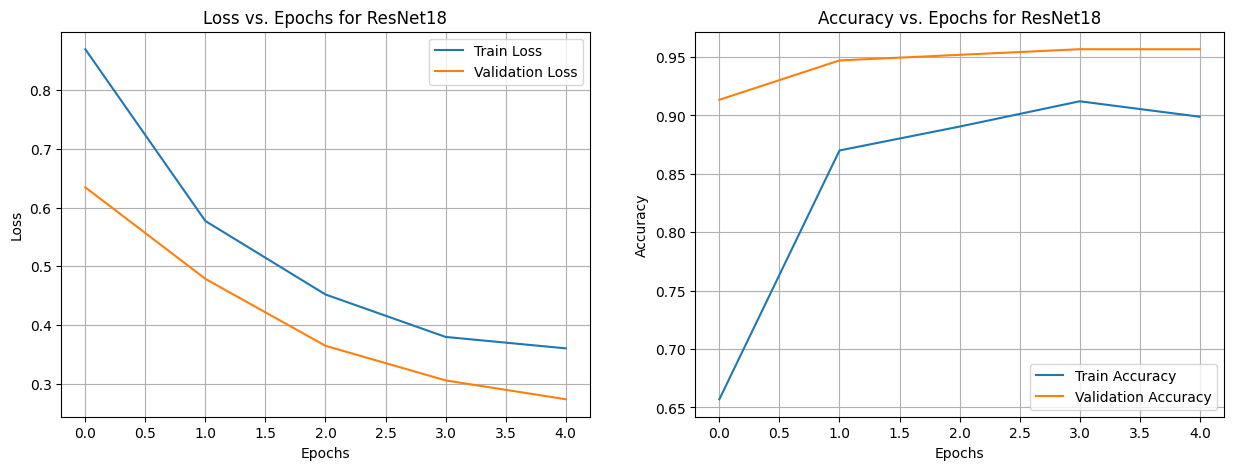

In [8]:
# --- Ячейка 7: Визуализация кривых обучения для ResNet18 ---

def plot_history(history, model_name):
    """Функция для отрисовки графиков обучения."""
    
    # Создаем фигуру с двумя областями для графиков (одна строка, два столбца)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # --- График 1: Потери (Loss) ---
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title(f'Loss vs. Epochs for {model_name}')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # --- График 2: Точность (Accuracy) ---
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title(f'Accuracy vs. Epochs for {model_name}')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    # Показываем графики
    plt.show()

# Вызываем нашу функцию для отрисовки
plot_history(history_resnet, 'ResNet18')

Анализ графиков ResNet18:
График потерь (слева): Обе кривые (Train и Validation) уверенно идут вниз. Это идеально. Значит, модель не переобучается, а именно учится обобщать знания, а не просто зазубривать картинки. Кривая валидации (оранжевая) даже ниже, чем кривая обучения — это отличный знак, говорящий о хорошем качестве модели.
График точности (справа): Обе кривые уверенно идут вверх. Валидационная точность (оранжевая) очень быстро достигла высокого плато в районе 95%, что подтверждает наши цифры.
Вывод: Модель ResNet18 отлично справилась с задачей.


In [9]:
# --- Ячейка 8: Обучение модели EfficientNet_b0 ---

# --- 1. Задаем гиперпараметры обучения ---
# Используем те же параметры, чтобы сравнение было честным
LEARNING_RATE = 0.001 
NUM_EPOCHS = 5

# --- 2. Определяем функцию потерь и оптимизатор ---
criterion_efficientnet = nn.CrossEntropyLoss()

# На этот раз передаем в оптимизатор параметры "головы" от EfficientNet
optimizer_efficientnet = optim.Adam(model_efficientnet.classifier.parameters(), lr=LEARNING_RATE)

# --- 3. Запускаем процесс обучения! ---
history_efficientnet = fit(
    model=model_efficientnet, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion_efficientnet, 
    optimizer=optimizer_efficientnet, 
    device=DEVICE, 
    num_epochs=NUM_EPOCHS
)

Начинаем обучение модели на 5 эпох...

--- Эпоха 1 / 5 ---


Training:   0%|          | 0/52 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Эпоха завершена.
	Train Loss: 0.5592 | Train Acc: 0.8448
	Val Loss: 0.3032   | Val Acc: 0.9471

--- Эпоха 2 / 5 ---


Training:   0%|          | 0/52 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Эпоха завершена.
	Train Loss: 0.2900 | Train Acc: 0.9110
	Val Loss: 0.2235   | Val Acc: 0.9423

--- Эпоха 3 / 5 ---


Training:   0%|          | 0/52 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Эпоха завершена.
	Train Loss: 0.2461 | Train Acc: 0.9194
	Val Loss: 0.2045   | Val Acc: 0.9519

--- Эпоха 4 / 5 ---


Training:   0%|          | 0/52 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Эпоха завершена.
	Train Loss: 0.2054 | Train Acc: 0.9398
	Val Loss: 0.1770   | Val Acc: 0.9519

--- Эпоха 5 / 5 ---


Training:   0%|          | 0/52 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Эпоха завершена.
	Train Loss: 0.2128 | Train Acc: 0.9242
	Val Loss: 0.1654   | Val Acc: 0.9519

Обучение завершено!


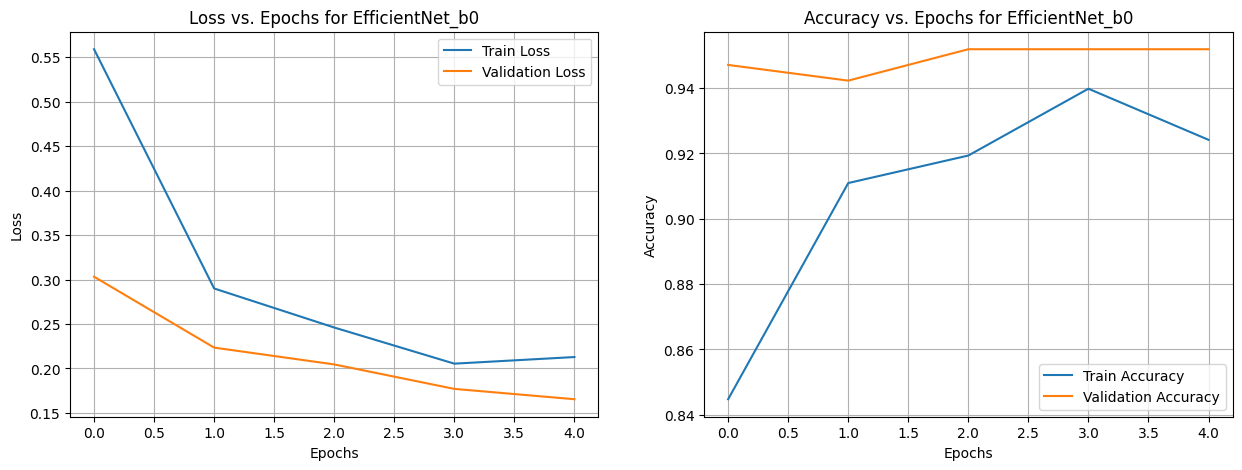

In [10]:
# --- Ячейка 9: Визуализация кривых обучения для EfficientNet_b0 ---

# Вызываем нашу функцию для отрисовки графиков для второй модели
plot_history(history_efficientnet, 'EfficientNet_b0')

Графики для EfficientNet тоже выглядят отлично и подтверждают наш вывод. Кривые потерь стабильно идут вниз, а кривые точности — вверх. Модель обучилась хорошо и без признаков переобучения.
Итак, наш выбор сделан. Лучшая модель — EfficientNet_b0, так как при практически одинаковой точности с ResNet18 она показала более низкий loss, что говорит о большей "уверенности" модели в своих ответах.

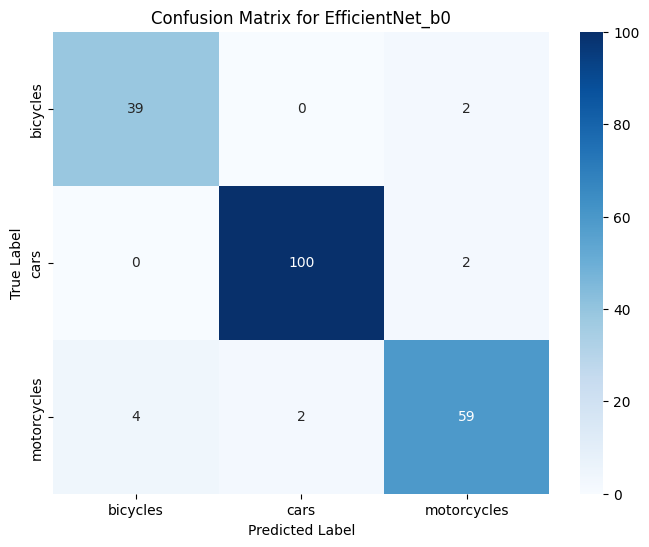

In [12]:
# --- Ячейка 10: Матрица ошибок для лучшей модели (EfficientNet_b0) ---

# Импортируем необходимые функции из scikit-learn и seaborn для красивой визуализации
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Списки для хранения реальных меток и предсказаний модели
all_labels = []
all_preds = []

# Переводим модель в режим оценки
model_efficientnet.eval()

# Проходим по всем данным в валидационном загрузчике
with torch.no_grad():
    for inputs, labels in val_loader: # Здесь можно не использовать tqdm, так как это быстрый процесс
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        outputs = model_efficientnet(inputs)
        _, preds = torch.max(outputs, 1)

        # Сохраняем предсказания и реальные метки
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Строим матрицу ошибок
cm = confusion_matrix(all_labels, all_preds)

# Визуализируем матрицу ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for EfficientNet_b0')
plt.show()

In [13]:
# --- Ячейка 11: Экспорт лучшей модели (EfficientNet_b0) в формат ONNX ---

# 1. Убедимся, что модель в режиме оценки
model_efficientnet.eval()

# 2. Создадим "пустышку" - пример входных данных для модели.
#    ONNX'у нужно увидеть один пример, чтобы понять, какой формы данные будут приходить на вход.
#    Размер должен быть [batch_size, channels, height, width]
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE, device=DEVICE)

# 3. Определяем путь для сохранения файла
ONNX_PATH = "../app/model.onnx" # Сохраним модель прямо в папку будущего приложения

# 4. Выполняем экспорт
torch.onnx.export(
    model_efficientnet,               # наша модель
    dummy_input,                      # пример входных данных
    ONNX_PATH,                        # путь для сохранения
    export_params=True,               # сохранять обученные веса
    opset_version=11,                 # версия ONNX
    do_constant_folding=True,         # оптимизация
    input_names=['input'],            # имя для входного слоя
    output_names=['output'],          # имя для выходного слоя
    dynamic_axes={'input': {0: 'batch_size'}, # делаем размер батча динамическим
                  'output': {0: 'batch_size'}}
)

print(f"Модель успешно экспортирована в формат ONNX по пути: {os.path.abspath(ONNX_PATH)}")

C:\Users\k9514\AppData\Local\Temp\ipykernel_30540\2696464796.py:15: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Модель успешно экспортирована в формат ONNX по пути: d:\Unic\7 семестр\машинки\1lb\app\model.onnx
